In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [4]:
def read_csv(file):
    #čitanje csva
    df = pd.read_csv(file,usecols=['id','time'], parse_dates=['time'], encoding='latin1')
    #print(df)
    return df

In [5]:
def get_limits(month, year):
    if month!=12:
        end=pd.to_datetime("{}-{}-01 23:59:59".format(year,month+1))-pd.Timedelta(days=1)
    else:
        end=pd.to_datetime("{}-{}-01 23:59:59".format(year+1,1))-pd.Timedelta(days=1)
    beginning=pd.to_datetime("{}-{}-01 00:00:00".format(year,month))
    #print(end,beginning)
    return end, beginning

In [6]:
def calculate_diff(df, column, beginning, end):
    #oduzimanje susjednih redaka
    df['diff']=df[column].diff(periods=1)    
     #izračun razmaka između poč. mjeseca i prvog mjerenja
    df.loc[0,'diff']=df.loc[0, column] - beginning
    #izračun razmaka između kraja mjeseca i zadnjeg mjerenja
    df.loc[len(df)] = {'diff':end - df.loc[len(df)-1, column], column: end}

In [7]:
def filter_rows(step,df):
    df['index'] = range(len(df))
    df2=df[df['diff'] > step]
    #filtiranje samo redaka čiji je diff veci od odabranog step-a (i njihovih prethodnika)
    previous_row = df2['index'] - 1
    result = pd.concat([df[df['index'].isin(previous_row) ], df2])
    result.sort_index(inplace=True, ignore_index=True)
    #print(result)
    return result

In [8]:
def make_table(result, beginning,step):
    #print(result)
    if result.loc[0,'index']==0 and result.loc[0,'diff']>step:
        #prvi red ima rupu od poč. mjeseca tj prvi snimljeni trenutak je upao u trenutke s rupom
        new_df=pd.DataFrame({'start-time':[beginning], 'end-time':[result.loc[0,'time']], 'duration':[result.loc[0,'diff']]})
        #print(new_df)
        new_df=pd.concat([new_df,pd.DataFrame({
        'start-time': result['time'].iloc[1::2].reset_index(drop=True),
        'end-time': result['time'].iloc[2::2].reset_index(drop=True),
        'duration': result['diff'].iloc[2::2].reset_index(drop=True)
        })], ignore_index=True)
        #print(new_df)
    else:
        #nema rupe od poč. mjeseca, uzimam parove redaka
        new_df = pd.DataFrame({
            'start-time': result['time'].iloc[0::2].reset_index(drop=True),
            'end-time': result['time'].iloc[1::2].reset_index(drop=True),
            'duration': result['diff'].iloc[1::2].reset_index(drop=True)
        })
    return new_df

In [29]:
def obrada(month, year, step):
    #step definira koja je granica za rupu
    df = read_csv(r"D:\Users\matea\Documents\3.god\projekt_r\bojler\{}\bojler_{}_{}.csv".format(year,month,year))
    end, beginning = get_limits(month, year)
    #nijedan podatak nije zabiljezen u mjesecu
    if df.empty:
        df=pd.DataFrame({'start-time':[beginning], 'end-time':[end], 'duration':[end-beginning]})
        return df
    #izračun rupa između mjerenja
    calculate_diff(df,'time', beginning, end)
    #print(df)
    #filtriranje rupa vecih od stepa
    result = filter_rows(step,df)
    if(result.empty):
        print("nema rupa")
        return result
    #formiranje tablice u obliku start - end - duration
    final_result = make_table(result, beginning,step)
    #print(final_result)
    #final_result.to_excel("bojler\{}\{}_{}.xlsx".format(year,month,year))
    return final_result

In [10]:
def generate_all_timestamps(beginning, end, frequency):
    all_timestamps = pd.date_range(start=beginning, end=end, freq=frequency)
    return all_timestamps

In [11]:
def check_holes(all_timestamps, df):
    is_within_interval_list = [
        any((timestamp >= row['start-time']) and (timestamp <= row['end-time']) for i, row in df.iterrows())
        for timestamp in all_timestamps
    ]
    return is_within_interval_list
    

In [12]:
def check_holes_better(all_timestamps, df, beginning):
    is_within_interval_list = []
    i = 0
    #print(df['start-time'].iloc[0], beginning)
    if df['start-time'].iloc[0]==beginning:
        i+=1
        is_within_interval_list.append(True)
    for index, row in df.iterrows():
        while i < len(all_timestamps) and all_timestamps[i] <= row['start-time']:
            is_within_interval_list.append(False)
            i += 1
        while i < len(all_timestamps) and all_timestamps[i] > row['start-time'] and all_timestamps[i] < row['end-time']:
            is_within_interval_list.append(True)
            i += 1
    while i < len(all_timestamps):
        is_within_interval_list.append(False)
        i += 1
    return is_within_interval_list

In [47]:
def create_graph(ax, all_timestamps, beginning, end, month, interval_list,step,pctg):
    
    ax.plot(all_timestamps, interval_list, linewidth=2)
    tick_positions = pd.date_range(start=beginning, end=end, freq='5D')
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=20)
    
    ax.set_xlabel('vrijeme', fontsize=20)
    ax.set_ylabel('1 - rupa, 0 - zapis', fontsize=20)
    if int(step.total_seconds())<60 :
        ax.set_title("rupa:>{}s, postotak:{}%".format(int(step.total_seconds()), round(pctg,2)), fontsize = 20)
    else:
        ax.set_title("rupa:>{}min, postotak:{}%".format(int(step.total_seconds()/60), round(pctg,2)), fontsize = 20)
    
    #fig.set_size_inches(20, 6)
    #plt.savefig("{}m_graph.png".format(month), dpi=600, bbox_inches='tight')
    return


In [42]:
def make_graph(month,year, steps, save):
    #print("{}. mjesec".format(month))
    end, beginning = get_limits(month, year)
    #generiranje svih 'trenutaka' u mjesecu kad bi podaci trebali biti upisani
    all_timestamps = generate_all_timestamps(beginning, end, '1S')
    #stvaranje novog prozora za novi mjesec
    plt.rcParams['agg.path.chunksize'] = 1000
    fig, ax = plt.subplots(nrows=1, ncols=len(steps), figsize=(20, 5))
    #fig.suptitle("{}. mjesec {}.".format(month,year), fontsize=22)
    k=0
    for step in steps:
        df=obrada(month,year,step)
        if(df.empty):
            interval_list=[False]*len(all_timestamps);
            percentage = 0;
        #true za trenutke koji su u rupi, false za one koji nisu
        else :
            interval_list = check_holes_better(all_timestamps, df, beginning)
            percentage = interval_list.count(True)/len(interval_list)*100
        #print("Postotak rupa: {} %, rupa:> {}".format(round(percentage,2),step))
        #stvaranje grafa
        if len(steps)==1:
            create_graph(ax, all_timestamps, beginning, end, month, interval_list, step, percentage)
        else:   
            create_graph(ax[k], all_timestamps, beginning, end, month, interval_list, step, percentage)
        k+=1
    #plt.title("{}. mjesec".format(month))
    #plt.savefig("spremljeno10", dpi=600, bbox_inches='tight')
    if save:
        plt.savefig("{}_{}_graph_latex.png".format(month,year), dpi=600, bbox_inches='tight')
    plt.show() 
    return



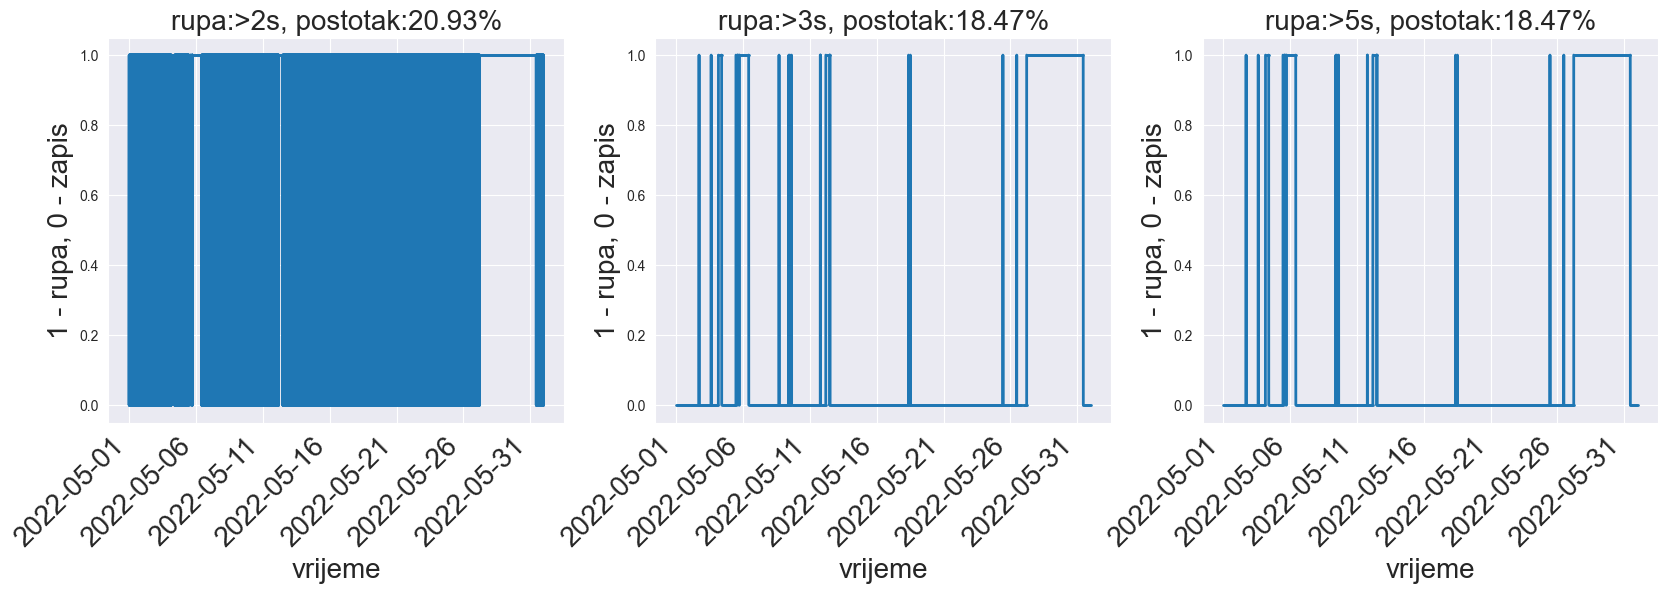

In [49]:
steps=[pd.to_timedelta('00:00:02'),pd.to_timedelta('00:00:03'),pd.to_timedelta('00:00:05')]
#steps=[pd.to_timedelta('00:05:00'), pd.to_timedelta('00:30:00')]
for i in range(5,6):
    make_graph(i,2022,steps, False)
#for i in range(4,12):
 #  make_graph(i, step)

In [19]:
pd.to_timedelta('00:05:00'), pd.to_timedelta('00:30:00')

NameError: name 'ax' is not defined

In [ ]:
steps=[pd.to_timedelta('00:00:02'),pd.to_timedelta('00:00:03'),pd.to_timedelta('00:00:05'),pd.to_timedelta('00:00:07'),pd.to_timedelta('00:00:10')]
for i in range (4,13):
    make_graph(i,2022,steps, True)
for i in range(1,12
               ):
    make_graph(i,2023,steps, True)


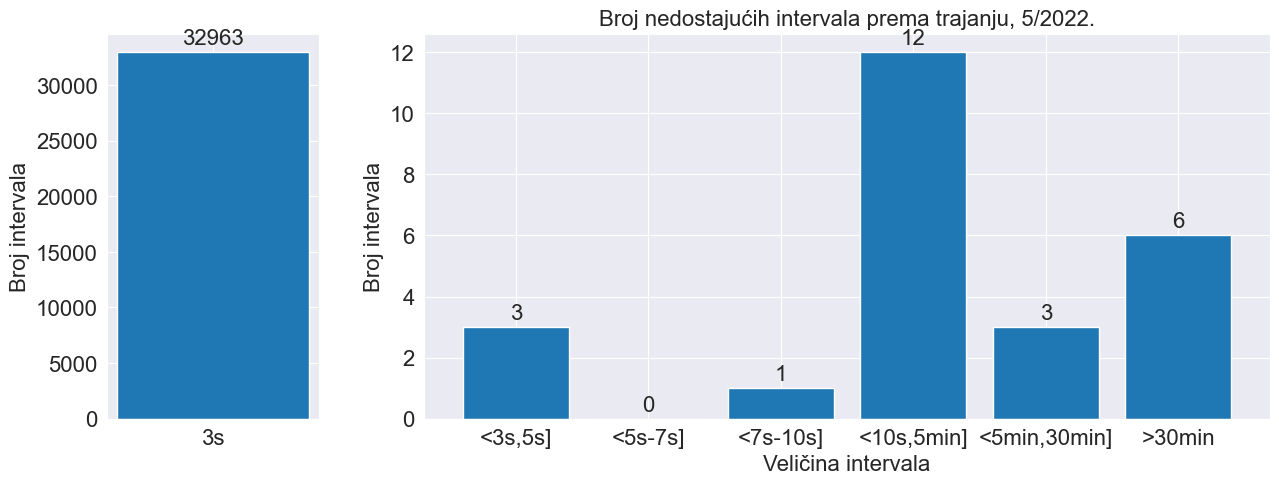

In [38]:
for i in range(5,6):
    tablica_rupa=obrada(i,2022,pd.to_timedelta('00:00:02'))
    data = {
        'Veličina rupe': ['3s','<3s,5s]','<5s-7s]','<7s-10s]','<10s,5min]', '<5min,30min]', '>30min'],
        'Broj rupa': [
            tablica_rupa[(tablica_rupa['duration'] == pd.to_timedelta('00:00:03'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:03')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:05'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:05')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:07'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:07')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:10'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:10')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:05:00'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:05:00')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:30:00'))].shape[0],
            tablica_rupa[tablica_rupa['duration'] > pd.to_timedelta('00:30:00')].shape[0]
        ]
    }
    rupe = pd.DataFrame(data, columns=['Broj rupa', 'Veličina rupe'])
   
    df_subset = rupe.head(1)
    df_subset2 = rupe.tail(6)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [1, 4]})
    
    ax1.bar(df_subset['Veličina rupe'], df_subset['Broj rupa'], width=0.1, align='center')
    ax1.set_ylabel('Broj intervala',fontsize=16)
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    
    ax2.bar(df_subset2['Veličina rupe'], df_subset2['Broj rupa'])
    ax2.set_xlabel('Veličina intervala',fontsize=16)
    ax2.set_ylabel('Broj intervala',fontsize=16)
    for p in ax2.patches:
        ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=16)
    plt.title("Broj nedostajućih intervala prema trajanju, {}/{}.".format(i,2022),fontsize=16) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.savefig("{}_{}_rupe.png".format(i,2023), dpi=600, bbox_inches='tight')
    plt.show()

In [ ]:
#vrste rupa: 3-10s, 10s-5 min, 5min-30 min, vise od 30 min
data = {
    'Veličina rupe': ['3s','[3s,5s>','[5s-7s>','[7s-10s>','[10s,5min>', '[5min,30min>', '>=30min'],
    'Broj rupa': [
        tablica_rupa[(tablica_rupa['duration'] == pd.to_timedelta('00:00:03'))].shape[0],
        tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:03')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:05'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:05')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:07'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:07')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:10'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:10')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:05:00'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:05:00')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:30:00'))].shape[0],
            tablica_rupa[tablica_rupa['duration'] > pd.to_timedelta('00:30:00')].shape[0]
    ]
}
rupe = pd.DataFrame(data, columns=['Broj rupa', 'Veličina rupe'])
print(rupe)

In [ ]:
obrada(6,2022,pd.to_timedelta('00:00:06'))